**VGG16 Model** 

In [1]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
import cv2  

Using TensorFlow backend.


In [2]:
# dimensions of our images. I reduced the dimensions to speed up the model training and because this resolution still yields high accuracy  

img_width, img_height = 150, 75  
   
top_model_weights_path = 'bottleneck_fc_model.h5'  
train_data_dir = 'C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/leapGestRecog/Training Set'   
test_data_dir = 'C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/leapGestRecog/Testing Set'  
   
# number of epochs to train top model  
epochs = 20  
# batch size used by flow_from_directory and predict_generator  
batch_size = 16  

In [3]:
vgg16 = applications.VGG16(include_top=False, weights='imagenet')  

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(  
    generator, predict_size_train, verbose = 1)  
 
np.save('vgg16_bottleneck_features_train.npy', bottleneck_features_train)  

Found 18000 images belonging to 10 classes.
1125/1125 [==============================] - 1584s 1s/step


In [5]:
generator = datagen.flow_from_directory(  
    test_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test, verbose = 1)  
   
np.save('vgg16_bottleneck_features_test.npy', bottleneck_features_test)  

Found 2000 images belonging to 10 classes.
125/125 [==============================] - 179s 1s/step


In [6]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
        train_data_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode='categorical',  
        shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('vgg16_bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 18000 images belonging to 10 classes.


In [7]:
generator_top = datagen_top.flow_from_directory(  
        test_data_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode=None,  
        shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('vgg16_bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 2000 images belonging to 10 classes.


In [8]:
import random

# We shuffle the data so that the validation split is able to represent a truly random sample of the data
idx = np.random.permutation(len(train_data))
train_data,train_labels = train_data[idx], train_labels[idx]

In [9]:
from keras.callbacks import ModelCheckpoint  
    
vgg16_model = Sequential()  
vgg16_model.add(Flatten(input_shape=train_data.shape[1:]))  
vgg16_model.add(Dense(512, activation='relu'))  
vgg16_model.add(Dropout(0.3))  
vgg16_model.add(Dense(num_classes, activation='softmax'))  
   
vgg16_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])  
 
checkpointer = ModelCheckpoint(filepath='C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_vgg16.hdf5', 
                              verbose=1, save_best_only=True)   


history = vgg16_model.fit(train_data, train_labels,  
         epochs=epochs,  
         batch_size=batch_size,
         callbacks=[checkpointer],
         validation_split = 0.1)  
  
vgg16_model.save_weights(top_model_weights_path)  
   
(test_loss, test_accuracy) = vgg16_model.evaluate(  
    test_data, test_labels, batch_size = batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(test_accuracy * 100))  
print("[INFO] Loss: {}".format(test_loss))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 16200 samples, validate on 1800 samples
Epoch 1/20
16200/16200 [==============================] - 24s 1ms/step - loss: 0.1941 - acc: 0.9435 - val_loss: 0.1241 - val_acc: 0.9856

Epoch 00001: val_loss improved from inf to 0.12411, saving model to C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_vgg16.hdf5
Epoch 2/20
16200/16200 [==============================] - 25s 2ms/step - loss: 0.0551 - acc: 0.9849 - val_loss: 0.0370 - val_acc: 0.9867

Epoch 00002: val_loss improved from 0.12411 to 0.03697, saving model to C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_vgg16.hdf5
Epoch 3/20
16200/16200 [==============================] - 23s 1ms/step - loss: 0.0501 - acc: 0.9864 - val_loss: 0.0990 - val_acc: 0.9867

Epoch 00003: val_loss did not improve from 0.03697
Epoch

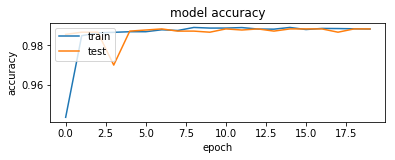

In [10]:
plt.figure(1)  
   
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

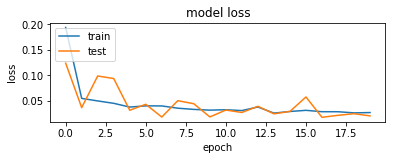

In [11]:
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  

**InceptionV3**

In [12]:
 incv3 = applications.InceptionV3(include_top=False, weights='imagenet')  

In [13]:
 datagen = ImageDataGenerator(rescale=1. / 255)  
   
 generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
 nb_train_samples = len(generator.filenames)  
 num_classes = len(generator.class_indices)  
   
 predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
 bottleneck_features_train = incv3.predict_generator(  
     generator, predict_size_train, verbose = 1)  
   
 np.save('incv3_bottleneck_features_train.npy', bottleneck_features_train)  

Found 18000 images belonging to 10 classes.
1125/1125 [==============================] - 400s 356ms/step


In [15]:
generator = datagen.flow_from_directory(  
    test_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = incv3.predict_generator(  
    generator, predict_size_test, verbose = 1)  
   
np.save('incv3_bottleneck_features_test.npy', bottleneck_features_test)  

Found 2000 images belonging to 10 classes.
125/125 [==============================] - 40s 316ms/step


In [16]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
        train_data_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode='categorical',  
        shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('incv3_bottleneck_features_train.npy')  
  
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 18000 images belonging to 10 classes.


In [17]:
generator_top = datagen_top.flow_from_directory(  
        test_data_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode=None,  
        shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('incv3_bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 2000 images belonging to 10 classes.


In [18]:
idx = np.random.permutation(len(train_data))
train_data,train_labels = train_data[idx], train_labels[idx]

In [19]:
 incv3_model = Sequential()  
 incv3_model.add(Flatten(input_shape=train_data.shape[1:]))  
 incv3_model.add(Dense(512, activation='relu'))  
 incv3_model.add(Dropout(0.3))  
 incv3_model.add(Dense(num_classes, activation='softmax'))  
   
 incv3_model.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy'])  
   
checkpointer = ModelCheckpoint(filepath='C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_vgg16.hdf5', 
                              verbose=1, save_best_only=True)   


history = incv3_model.fit(train_data, train_labels,  
         epochs=epochs,  
         batch_size=batch_size,
         callbacks=[checkpointer],
         validation_split = 0.1)   
   
 incv3_model.save_weights(top_model_weights_path)  
   
 (test_loss, test_accuracy) = incv3_model.evaluate(  
     test_data, test_labels, batch_size=batch_size, verbose=1)

 print("[INFO] accuracy: {:.2f}%".format(test_accuracy * 100))  
 print("[INFO] Loss: {}".format(test_loss)) 

Train on 16200 samples, validate on 1800 samples
Epoch 1/20
16200/16200 [==============================] - 37s 2ms/step - loss: 0.5410 - acc: 0.9286 - val_loss: 0.0433 - val_acc: 0.9861

Epoch 00001: val_loss improved from inf to 0.04327, saving model to C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_vgg16.hdf5
Epoch 2/20
16200/16200 [==============================] - 36s 2ms/step - loss: 0.1453 - acc: 0.9781 - val_loss: 0.1668 - val_acc: 0.9717

Epoch 00002: val_loss did not improve from 0.04327
Epoch 3/20
16200/16200 [==============================] - 37s 2ms/step - loss: 0.0825 - acc: 0.9846 - val_loss: 0.0419 - val_acc: 0.9906

Epoch 00003: val_loss improved from 0.04327 to 0.04191, saving model to C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_vgg16.hdf5
Epoch 4/20
16200/16200 [==============================] - 36s 2ms/step - loss: 0.0509 - acc: 0.9870 - val_loss: 0.0181 - val_acc: 0.9894

Epoch 00005: val_loss improved

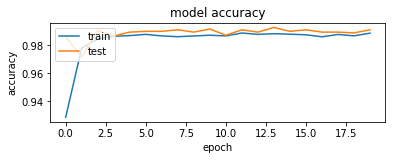

In [20]:
 plt.figure(1)  
   
 # summarize history for accuracy  
   
 plt.subplot(211)  
 plt.plot(history.history['acc'])  
 plt.plot(history.history['val_acc'])  
 plt.title('model accuracy')  
 plt.ylabel('accuracy')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left') 

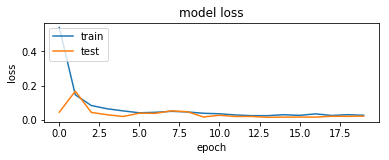

In [21]:
 # summarize history for loss  
   
 plt.subplot(212)  
 plt.plot(history.history['loss'])  
 plt.plot(history.history['val_loss'])  
 plt.title('model loss')  
 plt.ylabel('loss')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  
 plt.show()  

**ResNet50**

In [22]:
resnet50 = applications.ResNet50(include_top=False, weights='imagenet')  

C:\Users\a_m_9\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 41s 0us/step


In [23]:
datagen = ImageDataGenerator(rescale=1. / 255)  
   
generator = datagen.flow_from_directory(  
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = resnet50.predict_generator(  
    generator, predict_size_train, verbose = 1)  
   
np.save('resnet50_bottleneck_features_train.npy', bottleneck_features_train)  

Found 18000 images belonging to 10 classes.
1125/1125 [==============================] - 927s 824ms/step


In [24]:
generator = datagen.flow_from_directory(  
    test_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = resnet50.predict_generator(  
    generator, predict_size_test, verbose = 1)  
   
np.save('resnet50_bottleneck_features_test.npy', bottleneck_features_test)  

Found 2000 images belonging to 10 classes.
125/125 [==============================] - 106s 844ms/step


In [25]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
        train_data_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode='categorical',  
        shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('resnet50_bottleneck_features_train.npy')  
   

# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 18000 images belonging to 10 classes.


In [26]:
generator_top = datagen_top.flow_from_directory(  
        test_data_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode=None,  
        shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('resnet50_bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 2000 images belonging to 10 classes.


In [27]:
# We shuffle the data so that the validation split is able to represent a truly random sample of the data
train_data,train_labels = train_data[idx], train_labels[idx]

In [28]:
resnet50_model = Sequential()  
resnet50_model.add(Flatten(input_shape=train_data.shape[1:]))  
resnet50_model.add(Dense(512, activation='relu'))  
resnet50_model.add(Dropout(0.3))  
resnet50_model.add(Dense(num_classes, activation='softmax'))  
   
resnet50_model.compile(optimizer='rmsprop',  
             loss='categorical_crossentropy', metrics=['accuracy'])  
 
checkpointer = ModelCheckpoint(filepath='C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_resnet50.hdf5', 
                              verbose=1, save_best_only=True)   
    
history = resnet50_model.fit(train_data, train_labels,  
         epochs=epochs,  
         batch_size=batch_size,
         callbacks=[checkpointer],
         validation_split = 0.1)  
  
resnet50_model.save_weights(top_model_weights_path)  
   
(test_loss, test_accuracy) = resnet50_model.evaluate(  
    test_data, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(test_accuracy * 100))  
print("[INFO] Loss: {}".format(test_loss))  

Train on 16200 samples, validate on 1800 samples
Epoch 1/20
16200/16200 [==============================] - 152s 9ms/step - loss: 1.4667 - acc: 0.5416 - val_loss: 0.5723 - val_acc: 0.8372

Epoch 00001: val_loss improved from inf to 0.57226, saving model to C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_resnet50.hdf5
Epoch 2/20
16200/16200 [==============================] - 149s 9ms/step - loss: 0.6094 - acc: 0.7977 - val_loss: 0.2837 - val_acc: 0.9133

Epoch 00002: val_loss improved from 0.57226 to 0.28368, saving model to C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_resnet50.hdf5
Epoch 3/20
16200/16200 [==============================] - 148s 9ms/step - loss: 0.4270 - acc: 0.8540 - val_loss: 0.4447 - val_acc: 0.8672

Epoch 00003: val_loss did not improve from 0.28368
Epoch 4/20
16200/16200 [==============================] - 149s 9ms/step - loss: 0.3451 - acc: 0.8805 - val_loss: 0.1981 - val_acc: 0.9206

Epoch 00004: val_los

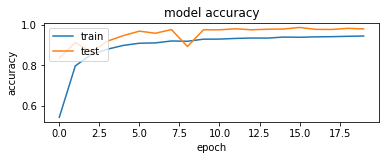

In [29]:
 plt.figure(1)  
   
 # summarize history for accuracy  
   
 plt.subplot(211)  
 plt.plot(history.history['acc'])  
 plt.plot(history.history['val_acc'])  
 plt.title('model accuracy')  
 plt.ylabel('accuracy')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  

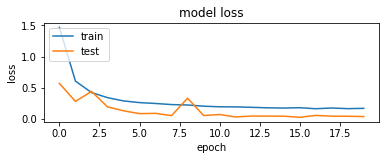

In [30]:
 # summarize history for loss  
   
 plt.subplot(212)  
 plt.plot(history.history['loss'])  
 plt.plot(history.history['val_loss'])  
 plt.title('model loss')  
 plt.ylabel('loss')  
 plt.xlabel('epoch')  
 plt.legend(['train', 'test'], loc='upper left')  
 plt.show()  

**Xception**

In [31]:
xception = applications.Xception(include_top=False, weights='imagenet')  

83689472/83683744 [==============================] - 33s 0us/step


In [32]:
datagen = ImageDataGenerator(rescale=1. / 255)  
   
generator = datagen.flow_from_directory(  
    train_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = xception.predict_generator(  
    generator, predict_size_train, verbose = 1)  
   
np.save('xception_bottleneck_features_train.npy', bottleneck_features_train)

Found 18000 images belonging to 10 classes.
1125/1125 [==============================] - 933s 829ms/step


In [33]:
generator = datagen.flow_from_directory(  
    test_data_dir,  
    target_size=(img_width, img_height),  
    batch_size=batch_size,  
    class_mode=None,  
    shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = xception.predict_generator(  
    generator, predict_size_test, verbose = 1)  
   
np.save('xception_bottleneck_features_test.npy', bottleneck_features_test)  

Found 2000 images belonging to 10 classes.
125/125 [==============================] - 98s 783ms/step


In [34]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
        train_data_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode='categorical',  
        shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('xception_bottleneck_features_train.npy')  
   

# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 18000 images belonging to 10 classes.


In [35]:
generator_top = datagen_top.flow_from_directory(  
        test_data_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode=None,  
        shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('xception_bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)  

Found 2000 images belonging to 10 classes.


In [37]:
# We shuffle the data so that the validation split is able to represent a truly random sample of the data
train_data,train_labels = train_data[idx], train_labels[idx]

In [38]:
xception_model = Sequential()  
xception_model.add(Flatten(input_shape=train_data.shape[1:]))  
xception_model.add(Dense(512, activation='relu'))  
xception_model.add(Dropout(0.3))  
xception_model.add(Dense(num_classes, activation='softmax'))  
   
xception_model.compile(optimizer='rmsprop',  
             loss='categorical_crossentropy', metrics=['accuracy'])  
 
checkpointer = ModelCheckpoint(filepath='C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_xception.hdf5', 
                              verbose=1, save_best_only=True)   
    
history = xception_model.fit(train_data, train_labels,  
         epochs=epochs,  
         batch_size=batch_size,
         callbacks=[checkpointer],
         validation_split = 0.1)  
  
xception_model.save_weights(top_model_weights_path)  
   
(test_loss, test_accuracy) = xception_model.evaluate(  
    test_data, test_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(test_accuracy * 100))  
print("[INFO] Loss: {}".format(test_loss))  

Train on 16200 samples, validate on 1800 samples
Epoch 1/20
16200/16200 [==============================] - 152s 9ms/step - loss: 4.2272 - acc: 0.7208 - val_loss: 1.9519 - val_acc: 0.8761

Epoch 00001: val_loss improved from inf to 1.95188, saving model to C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_xception.hdf5
Epoch 2/20
16200/16200 [==============================] - 150s 9ms/step - loss: 2.0625 - acc: 0.8674 - val_loss: 1.8955 - val_acc: 0.8811

Epoch 00002: val_loss improved from 1.95188 to 1.89548, saving model to C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_xception.hdf5
Epoch 3/20
16200/16200 [==============================] - 151s 9ms/step - loss: 1.9361 - acc: 0.8769 - val_loss: 1.8811 - val_acc: 0.8828

Epoch 00003: val_loss improved from 1.89548 to 1.88115, saving model to C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/weights.best.from_xception.hdf5
Epoch 4/20
16200/16200 [======================

In [256]:
from keras.preprocessing import image 
from keras.applications.vgg16 import VGG16, preprocess_input

This gesture is a c


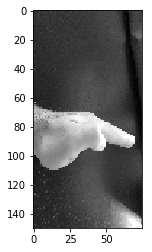

In [321]:
# Testing the model on random images

from skimage import color
from skimage import io

gestures = ['c', 'down', 'fist', 'fist_moved', 'index', 'l', 'ok', 'palm', 'palm_moved', 'thumb']
gesture = ""

img = image.load_img('C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/Practical Test/grayscale7.png', target_size = (150,75))
img_array = image.img_to_array(img)
plt.imshow(img)
img_array = np.expand_dims(img_array, axis=0)    
    
bottleneck_feature = VGG16(weights='imagenet', include_top=False).predict(preprocess_input(img_array))
   
gesture = vgg16_model.predict(bottleneck_feature)
index_max = np.argmax(gesture)
gesture = gestures[index_max]
print("This gesture is a", gesture)  

In [311]:
def gesture_classification(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (150,75))
    plt.imshow(img)
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis = 0)  
    print(img_array.shape)
    
    bottleneck_feature = VGG16(weights='imagenet', include_top=False).predict(preprocess_input(img_array))
   
    gesture = vgg16_model.predict(bottleneck_feature)
    index_max = np.argmax(gesture)
    gesture = gestures[index_max]
    print("This gesture is a", gesture)  

In [253]:
import os

directory = 'C:/Users/a_m_9/OneDrive/Documents/Machine Learning/Capstone/Practical Test/'
imagesList = os.listdir(directory)

i=1
for image in imagesList:
    path = directory+image
    img = Image.open(path).convert('LA')
    img.save('grayscale%s.png' % i)
    i+=1